In [ ]:
pm.checkForUpdate()
pm.verify()

In [1]:
import math
import scipy
import statistics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import genpareto
from scipy.stats import t as studentt
from statistics import mean
from scipy.optimize import minimize

import paramonte as pm
import seaborn as sns

In [14]:
# SYNTHETIC DATA GENERATION

# generate single record (full tide, truncated tide, and proxy records)
def create_record(distribution , parameters, proxy_cutoffs): # set up as a function so other distributions could be used to generate data
        
    if distribution == 'student_t': #using student t-distribution
        
        df = parameters[0]
        location = parameters[1]
        scale = parameters[2]
        
        # create timeline using one sample per day
        Nperyear = 365
        t1 = 1000
        t2 = 2000
        t = np.linspace(t1,t2,(t2-t1)*Nperyear+1)
        
        # sample water heights from student t-distribution
        h = studentt.ppf(np.random.rand(len(t)), df, location, scale)
        q99 = studentt.ppf(0.99, df, location, scale)
        
        # generate pseudo-tide gauge record
        
        def msltrend(yr):
            trend = (yr - t2)*1.5
            return trend
        
        # create "true", unobservable, full tide gauge record
        fulltg_t = t
        fulltg_h_notrend = h
        fulltg_h = fulltg_h_notrend + msltrend(fulltg_t)
        fulltg_h = fulltg_h - statistics.mean(fulltg_h[np.where(fulltg_t >= 1983)])
        sub99 = np.where(fulltg_h_notrend >= q99)
        fulltg_t99 = fulltg_t[sub99]
        fulltg_h_notrend99 = fulltg_h_notrend[sub99]
        
        # create truncated tide gauge record (from 1920 on)
        tg_firstyear = 1920
        sub = np.where(fulltg_t >= tg_firstyear)
        tg_t = fulltg_t[sub]
        tg_h_notrend = fulltg_h_notrend[sub]
        tg_h = fulltg_h[sub]
        sub99 = np.where(tg_h_notrend >= q99)
        tg_t99 = tg_t[sub99]
        tg_h_notrend99 = tg_h_notrend[sub99]
        
        # generate geologic record -- using geologic cutoffs
        # using z w/o trend
        cutoff = proxy_cutoffs[1]
        proxysub = np.where(h >= cutoff)
        proxy_t_true = t[proxysub]
        proxy_h_true = h[proxysub]
        proxy_h = np.full((1, len(np.transpose(proxysub))), max(proxy_h_true)+100)
        
        # determine number of geologic events exceeding each geologic cutoff
        num_h_cutoff=[]
        for x in range(0,len(proxy_cutoffs)):
            cur_cutoff = proxy_cutoffs[x]
            proxysubset = np.where(h>=cur_cutoff)
            proxyheight = h[proxysubset]
            number_h = len(proxyheight)
            num_h_cutoff.append(number_h)
            
        num_tide_cutoff=[]
        for y in range(0,len(proxy_cutoffs)):
            cur_cutoff = proxy_cutoffs[y]
            tidesubset = np.where(tg_h_notrend99>=cur_cutoff)
            tideheight = tg_h_notrend99[tidesubset]
            number_th = len(tideheight)
            num_tide_cutoff.append(number_th)
            
        num_diff_cutoff=[]
        for z in range(0,len(num_h_cutoff)):
            a = num_h_cutoff[z] - num_tide_cutoff[z]
            num_diff_cutoff.append(a)
            
        # add in age error - making error increase with age
        # assume can determine true ages where geologic record overlaps with historical record
        proxy_dt = np.ones(len(proxy_t_true)) * 10 + 0.030 * (t2 - proxy_t_true)
        proxy_dt = proxy_dt * (proxy_t_true < 1800)

        proxy_t = proxy_t_true + np.random.randn(len(proxy_t_true)) * proxy_dt
        
        # calculate true number of exceedances from survival function
        # testz = list(np.arange(q99,5000,1))
        testz = list(np.arange(545,3001,1))
        logN = studentt.sf(testz, df, location, scale)*365
        
        testlogNexc = logN
        

        
        return [fulltg_t, fulltg_h_notrend, fulltg_h, tg_t, tg_h_notrend, tg_h, proxy_t_true, proxy_h_true, proxy_h, num_h_cutoff, q99, fulltg_t99, fulltg_h_notrend99, tg_t99, tg_h_notrend99, testz, testlogNexc, num_tide_cutoff, num_diff_cutoff]
    
    
    
    

In [15]:
# generate record with student_t data
distribution = "student_t"
parameters = [9.365, 0.8957, 199.2]
proxy_cutoffs = [1250, 1350, 1450, 1650]

test_record = create_record(distribution, parameters, proxy_cutoffs)

fulltg_t = test_record[0]
fulltg_h_notrend = test_record[1]
fulltg_h = test_record[2]
tg_t = test_record[3]
tg_h_notrend = test_record[4]
tg_h = test_record[5]
proxy_t_true = test_record[6]
proxy_h_true = test_record[7]
proxy_h = test_record[8]
num_h_cutoff = test_record[9]
q99 = test_record[10]
fulltg_t_99 = test_record[11]
fulltg_h_notrend99 = test_record[12]
tg_t99 = test_record[13]
tg_h_notrend99 = test_record[14]
testz = test_record[15]
testlogNexc = test_record[16]
num_tide_cutoff = test_record[17]
num_diff_cutoff = test_record[18]


# print(q99)

In [16]:
print(q99)

558.400443561405


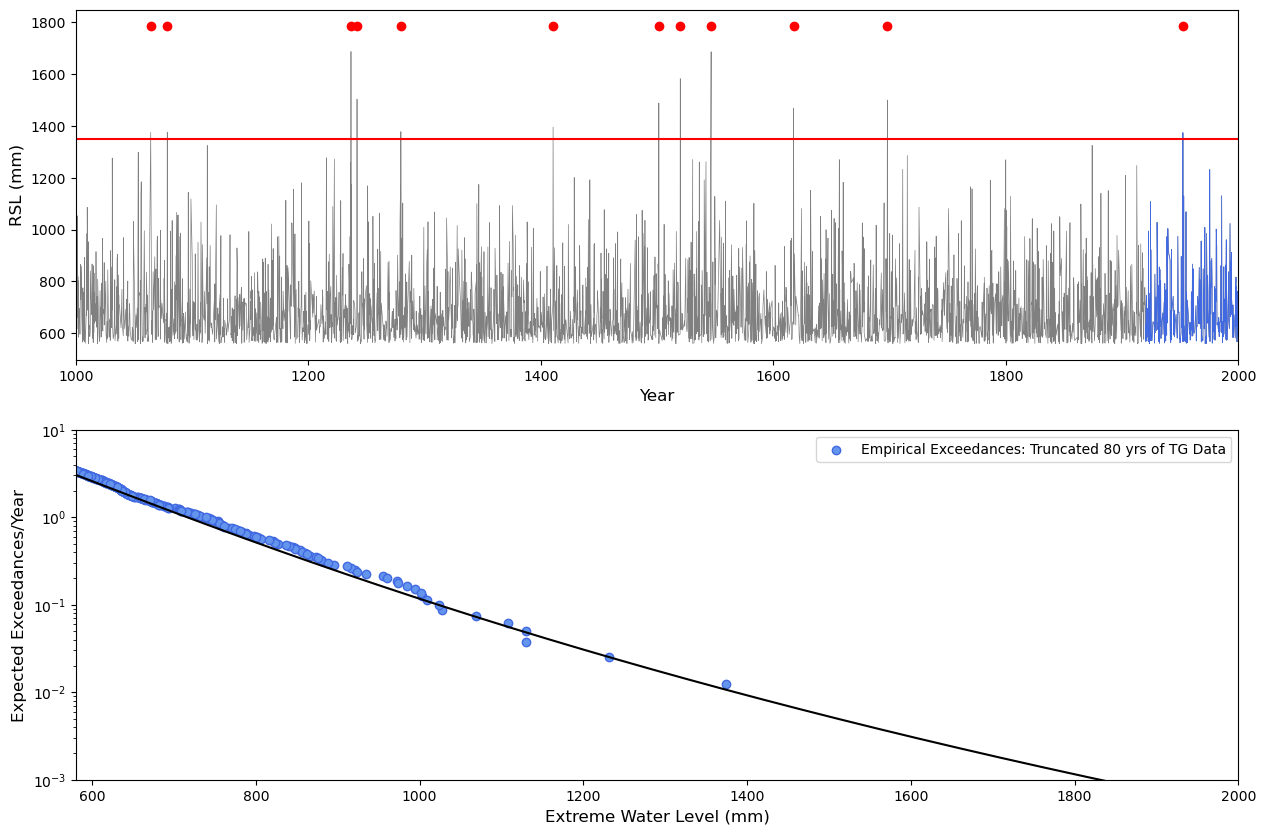

In [17]:
# explore data

# empirical exceedances
# testexc = fulltg_h_notrend99
testexc_tg = tg_h_notrend99

# exceeded = []
# for h in range(0, len(testexc)):
#     exc = sum(fulltg_h_notrend > testexc[h])/(len(fulltg_h_notrend)/365.00)
#     exceeded.append(exc)
    
exceeded_tide = []
for i in range(0, len(testexc_tg)):
    exc = sum(tg_h_notrend >= testexc_tg[i])/(len(tg_h_notrend)/365.00)
    exceeded_tide.append(exc)


fig = plt.figure(figsize=(15,10))
# ax = fig.add_subplot(311)
# plt.plot(fulltg_t, fulltg_h_notrend, color = 'gray', linewidth = '0.5')
# plt.plot(tg_t, tg_h_notrend, color = 'royalblue', linewidth = '0.5')
# plt.scatter(proxy_t_true, proxy_h, color = 'red') 
# ax.set_xlim([1000,2000])
# plt.xlabel('Year', fontsize = 12)
# plt.ylabel('RSL (mm)', fontsize = 12)

# plt.savefig("StudentTDist_Data", bbox_inches = 'tight')

# fig = plt.figure(figsize=(15,10))
ax3 = fig.add_subplot(212)
plt.plot(testz, testlogNexc, color = 'black')

# plt.scatter(testexc, exceeded, facecolors = 'none', edgecolors = 'gray', label = 'Empirical Exceedances: Full 1000 yrs of SL Data')
plt.scatter(testexc_tg, exceeded_tide, facecolors = 'cornflowerblue', edgecolors = 'royalblue', label = 'Empirical Exceedances: Truncated 80 yrs of TG Data')
ax3.set_yscale('log')
ax3.set_xlim([580, 2000])
ax3.set_ylim([1e-3, 10])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Expected Exceedances/Year', fontsize = 12)
plt.legend(loc = "upper right")

ax2 = fig.add_subplot(211)
plt.plot(fulltg_t_99, fulltg_h_notrend99, color = 'gray', linewidth = '0.5')
plt.plot(tg_t99, tg_h_notrend99, color = 'royalblue', linewidth = '0.5')
plt.scatter(proxy_t_true, proxy_h, color = 'red')
x = (1000,2000)
y = (1250,1250)
y2 = (1350,1350)
y3 = (1450,1450)
y4 = (1650,1650)
# plt.plot(x,y, color = 'coral')
plt.plot(x,y2, color = 'red')
# plt.plot(x,y3, color = 'orangered')
# plt.plot(x,y4, color = 'firebrick')
ax2.set_xlim([1000,2000])
plt.xlabel('Year', fontsize = 12)
plt.ylabel('RSL (mm)', fontsize = 12)

plt.savefig("StationaryCase_SyntheticDataEx.pdf", bbox_inches = 'tight', dpi = 300)


In [18]:
true_exceedances = np.column_stack((testz, testlogNexc))

true_exceedances = pd.DataFrame(true_exceedances, columns = ['Water Level (mm)', 'Exceedance Probability'])

true_exceedances.to_excel('true_exceedances.xlsx', index = False)

In [55]:
# define functions to be optimized (log likelihoods)

cutoff_data = test_record[18]  

geo_cutoffs = [1250, 1350, 1450, 1650]
geologic_id = 1

print(cutoff_data[geologic_id])

def function_a(z, mu, phi, xi): # just a funciton used in both likelihood functions
    
    return (np.log(1 + (xi * ((z - mu)/phi))))

# negative log likelihood for tide data & proxy data    
def log_likelihood(parameters):
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    tau = parameters[3]
    q_99 = 558.4 # using as tide threshold
    
    M = cutoff_data[geologic_id] # number of geologic observations
    # M = 0
    
    t1 = 1000
    t2 = 2000
    t_tide = 1920
    
# train on tide data

#     ll_geo_tide = ((-1 * len(test_record[14]) * np.log(phi)) +
#         ((-1 - (1/xi)) * np.sum(function_a(test_record[14], mu, phi, xi))) -
#         ((t2 - t_tide) * (1 + ((xi * (q_99 - mu))/phi))**(-1/xi)))
    
# train on geo data

    ll_geo_tide = (-((M/xi) * np.log(1 + (xi * ((tau - mu)/phi)))) -
        ((t_tide - t1) * (1 + ((xi * (tau - mu))/phi))**(-1/xi)))
    
# train on tide and geo data    
    
#     ll_geo_tide = ((-1 * len(test_record[14]) * np.log(phi)) +
#         ((-1 - (1/xi)) * np.sum(function_a(test_record[14], mu, phi, xi))) -
#         ((M/xi) * np.log(1 + (xi * ((tau - mu)/phi)))) -
#         ((t2 - t_tide) * (1 + ((xi * (q_99 - mu))/phi))**(-1/xi)) -
#         ((t_tide - t1) * (1 + ((xi * (tau - mu))/phi))**(-1/xi)))
    
    return(ll_geo_tide) 

def log_likelihood_tide(parameters): # using tide gauge data only
    
    q_99 = 558.4
    
    t2 = 2000
    t_tide = 1920 # start of tide gauge record
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    
    ll_tide = ((-1 * len(test_record[14]) * np.log(phi)) +
        ((-1 - (1/xi)) * np.sum(function_a(test_record[14], mu, phi, xi))) -
        ((t2 - t_tide) * (1 + ((xi * (q_99 - mu))/phi))**(-1/xi)))
    
    return(ll_tide)


11


In [56]:
# test negative log likelihood function - testing with initial parameter values

parameters0 = [600, 130, 0.1, 1300]
parameters0_tide = [600, 130, 0.1]

ans = log_likelihood(parameters0)
print(ans)

ans1 = log_likelihood_tide(parameters0)
print(ans1)

-59.771844647228576
-1881.8151102510888


In [21]:
pmpd_tide = pm.ParaDRAM() # instantiate an object of class ParaDRAM sampler Paradram()

In [22]:
pmpd_tide.spec.overwriteRequested = True # overwrite the existing output files just in case they already exist.
pmpd_tide.spec.outputFileName = "./out/ESL&GS_S_MCMC" # specify the output file prefixes.
pmpd_tide.spec.randomSeed = 12345 # set the random seed for the sake of reproducibity.
pmpd_tide.spec.variableNameList = ["mu", "phi", "xi"] # set the output names of the parameters.
pmpd_tide.spec.chainSize = 5000 # set the number of uniquely sampled points from the likelihood function.
pmpd_tide.spec.domainLowerLimitVec = [400, 100, 1e-10]
pmpd_tide.spec.domainUpperLimitVec = [1000, 500, 1]

In [23]:
pmpd_tide.runSampler( ndim = 3, # the number of parameters
               getLogFunc = log_likelihood_tide # the objective function to sample points from
               )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                    

                                      5000 / 31796             0.2105 / 0.1574             0.4331 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

In [24]:
chain_tide = pmpd_tide.readChain(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readChain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/ESL&GS_S_MCMC*_chain.txt"


ParaDRAM - NOTE: processing chain file: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms/out/ESL&GS_S_MCMC_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 0.021441 seconds.
ParaDRAM - NOTE: ndim = 3, count = 5000
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating a he

In [25]:
chain_tide.plot.scatter.scatter.kws.cmap = "winter" # change the color-mapping from the default "autumn"
# chain_tide.plot.scatter(ycolumns = "AdaptationMeasure" # choose the AdaptationMeasure column of the output chain file to plot
#                    , ccolumns = [] # set the color of the points to empty from the default logLikelihood value.
#                   )
# chain_tide.plot.scatter.currentFig.axes.set_ylim([1.e-5,1])
# chain_tide.plot.scatter.currentFig.axes.set_yscale("log")

In [26]:
sample_tide = pmpd_tide.readSample(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readSample()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the sample file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/ESL&GS_S_MCMC*_sample.txt"


ParaDRAM - NOTE: processing sample file: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms/out/ESL&GS_S_MCMC_process_1_sample.txt
ParaDRAM - NOTE: reading the file contents... done in 0.00502 seconds.
ParaDRAM - NOTE: ndim = 3, count = 1049
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating 

In [15]:
# plot the sampled variables

# for colname in sample_tide.df.columns:
#     sample_tide.plot.line.ycolumns = colname
#     sample_tide.plot.line()
#     sample_tide.plot.line.currentFig.axes.set_xlabel("MCMC Count")
#     sample_tide.plot.line.currentFig.axes.set_ylabel(colname)
#     sample_tide.plot.line.savefig( fname = "./out/traceplot_" + colname )

# # plot the histograms of the sampled parameters

# for colname in sample_tide.df.columns:
#     sample_tide.plot.histplot(xcolumns = colname)
#     sample_tide.plot.histplot.currentFig.axes.set_xlabel(colname)
#     sample_tide.plot.histplot.currentFig.axes.set_ylabel("MCMC Count")
#     sample_tide.plot.histplot.savefig( fname = "./out/histogram_" + colname )

In [27]:
sample_tide.df.mean()

SampleLogFunc   -1748.673550
mu                729.741940
phi               129.403898
xi                  0.073550
dtype: float64

In [28]:
sample_tide.df.std()

SampleLogFunc     1.224640
mu               12.412197
phi               8.472056
xi                0.050099
dtype: float64

In [29]:
sample_tide.df.quantile([0.05, 0.5, 0.95])

,SampleLogFunc,mu,phi,xi
0.05,-1751.22998,710.092346,117.099768,0.008025
0.50,-1748.37240,729.131840,128.789650,0.065459
0.95,-1747.31754,750.188660,144.109168,0.163509


ParaDRAM - NOTE: making the grid plot... 
generating subplot #1: (0,0) out of 16... done in 0.018568 seconds.
generating subplot #2: (0,1) out of 16... done in 0.170689 seconds.
generating subplot #3: (0,2) out of 16... done in 0.172865 seconds.
generating subplot #4: (0,3) out of 16... done in 0.170192 seconds.
generating subplot #5: (1,0) out of 16... done in 0.320505 seconds.
generating subplot #6: (1,1) out of 16... done in 0.018568 seconds.
generating subplot #7: (1,2) out of 16... done in 0.165731 seconds.
generating subplot #8: (1,3) out of 16... done in 0.175011 seconds.
generating subplot #9: (2,0) out of 16... done in 0.334435 seconds.
generating subplot #10: (2,1) out of 16... done in 0.315436 seconds.
generating subplot #11: (2,2) out of 16... done in 0.018568 seconds.
generating subplot #12: (2,3) out of 16... done in 0.166867 seconds.
generating subplot #13: (3,0) out of 16... done in 0.309943 seconds.
generating subplot #14: (3,1) out of 16... done in 0.313234 seconds.
g

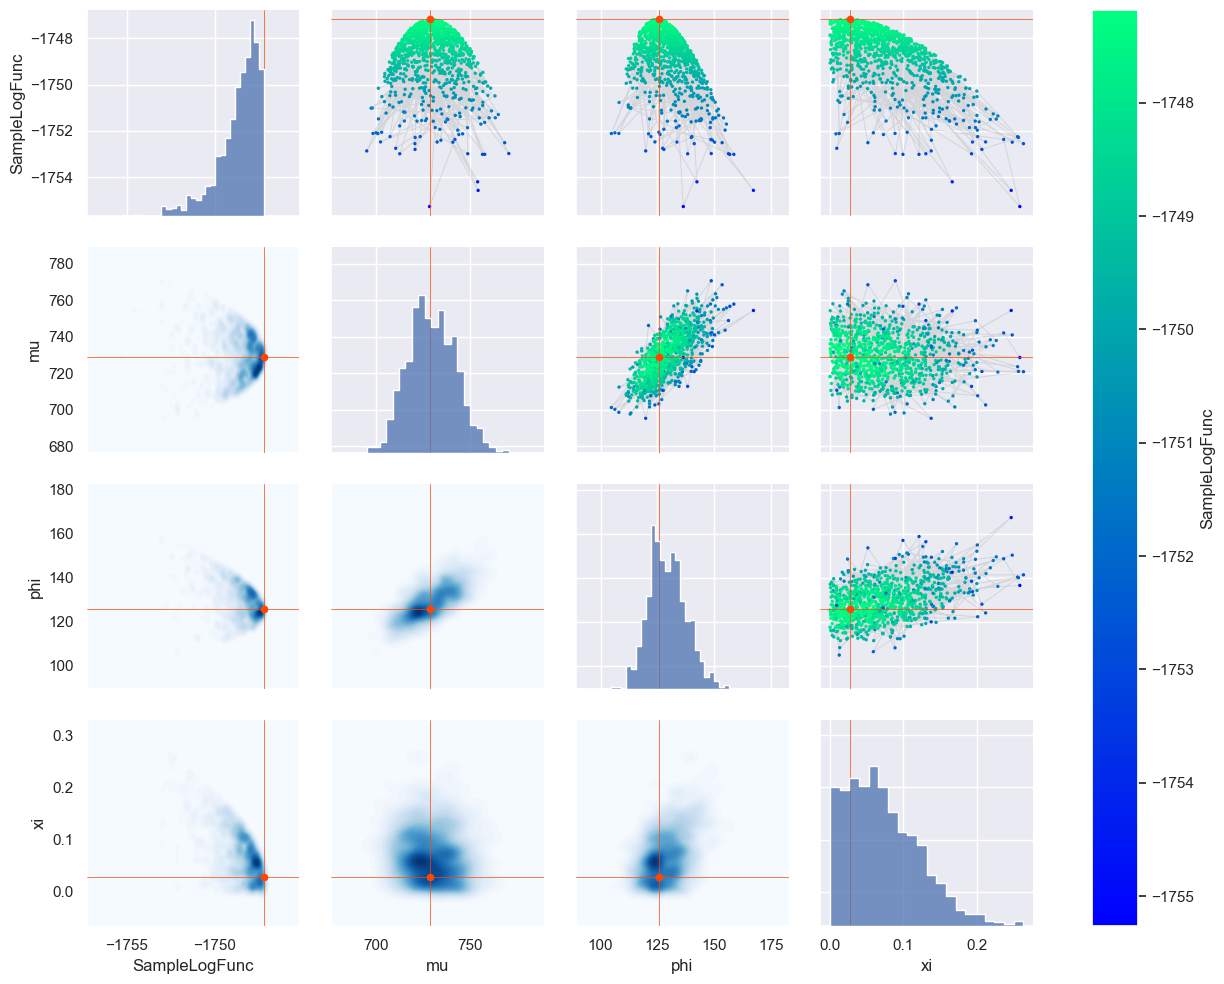

In [30]:
sample_tide.plot.grid.plotType.upper.enabled = True # disable upper triangle
sample_tide.plot.grid.plotType.lower.value = "contourf" # let lower triangle be lineScatter plot
sample_tide.plot.grid(columns = [0,1,2,3]) # make grid plot of all parameters
sample_tide.plot.grid.addTarget() # add the maximum-likelihood set of parameters as the target value to all plots

plt.savefig("Synthetic_MCMC_ParamValues_Tide", bbox_inches = 'tight', dpi = 300)


In [31]:
sample_tide.df

,SampleLogFunc,mu,phi,xi
0,-1748.9255,746.07049,141.54668,0.067444
1,-1748.0191,736.03765,131.46323,0.002753
2,-1749.1835,731.97396,122.86926,0.069444
3,-1748.5632,717.20277,115.04371,0.039291
4,-1750.4065,718.73937,135.76741,0.139872
...,...,...,...,...
1044,-1749.3739,706.89337,120.59597,0.091921
1045,-1747.9414,718.75372,120.72420,0.073061
1046,-1748.0980,741.50041,125.57553,0.006444
1047,-1747.9602,722.60284,128.79888,0.098251


In [32]:
runs = len(sample_tide.df)

In [33]:
z = []
for i in range(545, 3000):
    z.append(i) 
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append (x) # water heights to calculate return periods for

def n_z_tide (z):
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    
    for i in range(0, runs):
        
        expected_per_z = []
        
        for j in range(0, len(water_height_nums)):
            
            # optimized parameter values
            mu = sample_tide.df.loc[i, 'mu']
            phi = sample_tide.df.loc[i, 'phi']
            xi = sample_tide.df.loc[i, 'xi']
            
            c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
            expected_per_z.append(c)
                
        plt.plot(z, expected_per_z, color = 'lightgray')
    
    plt.plot(testz, testlogNexc, color = 'gray', label = 'True Return Curve')
    plt.scatter(testexc_tg, exceeded_tide, facecolors = 'none', edgecolors = 'cyan', label = 'Empirical Exceedances', zorder = 10000)

    ax.set_yscale('log')
    ax.set_ylim([1e-3, 1])
    ax.set_xlim([500, 3000])
    plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
    plt.ylabel('Number of Exceedances per Year', fontsize = 12)
    plt.legend(loc = "upper right")
    
    plt.savefig("Synthetic_MCMC_Curves_Tide", bbox_inches = 'tight', dpi = 300)

    
    return ()


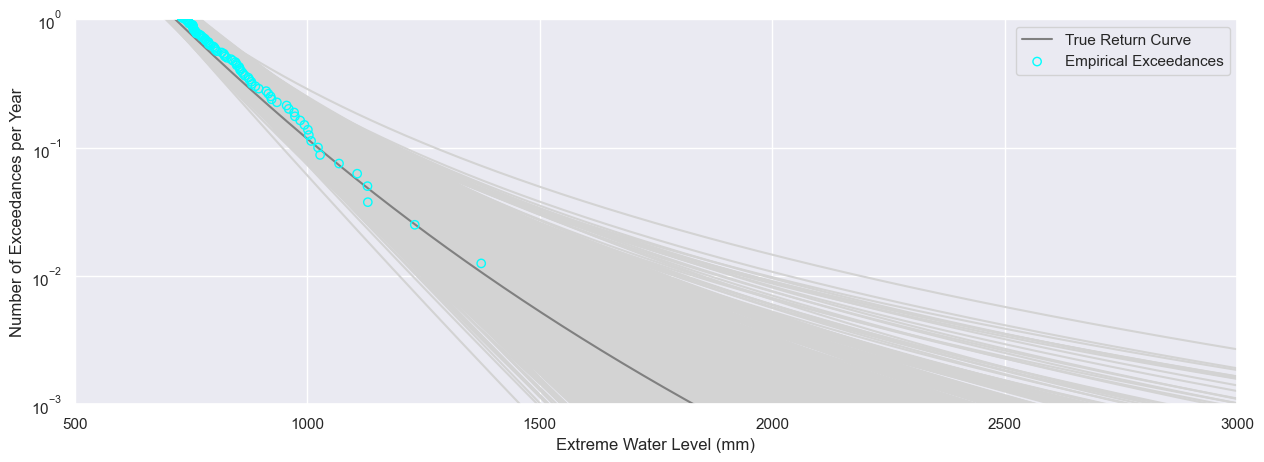

In [34]:
mcmc_curves_tide = n_z_tide(z)

In [35]:
# Quantiles for MCMC runs

z = []
for i in range(545, 3001):
    z.append(i)
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append(x)

q5 = []
q50 = []
q95 = []
q17 = []
q83 = []

    
for i in range(0, len(water_height_nums)):
    
    y = []
    
    for j in range(0, runs):
        
        # optimized parameter values
        mu = sample_tide.df.loc[j, 'mu']
        phi = sample_tide.df.loc[j, 'phi']
        xi = sample_tide.df.loc[j, 'xi']
        
        c = ((1 + (xi * (z[i] - mu)/phi))**(-1/xi))
        y.append(c)
        
    y_q5 = np.quantile(y, 0.05)
    q5.append(y_q5)
    y_q50 = np.quantile(y, 0.50)
    q50.append(y_q50)
    y_q95 = np.quantile(y, 0.95)
    q95.append(y_q95)
    y_q17 = np.quantile(y, 0.17)
    q17.append(y_q17)
    y_q83 = np.quantile(y, 0.83)
    q83.append(y_q83)
    
fin = np.column_stack((z, q5, q17, q50, q83, q95))

fin = pd.DataFrame(fin, columns = ['Water Level (mm)', 'q5', 'q17', 'q50', 'q83', 'q95'])

fin.to_excel('tide_quantiles.xlsx', index = False)

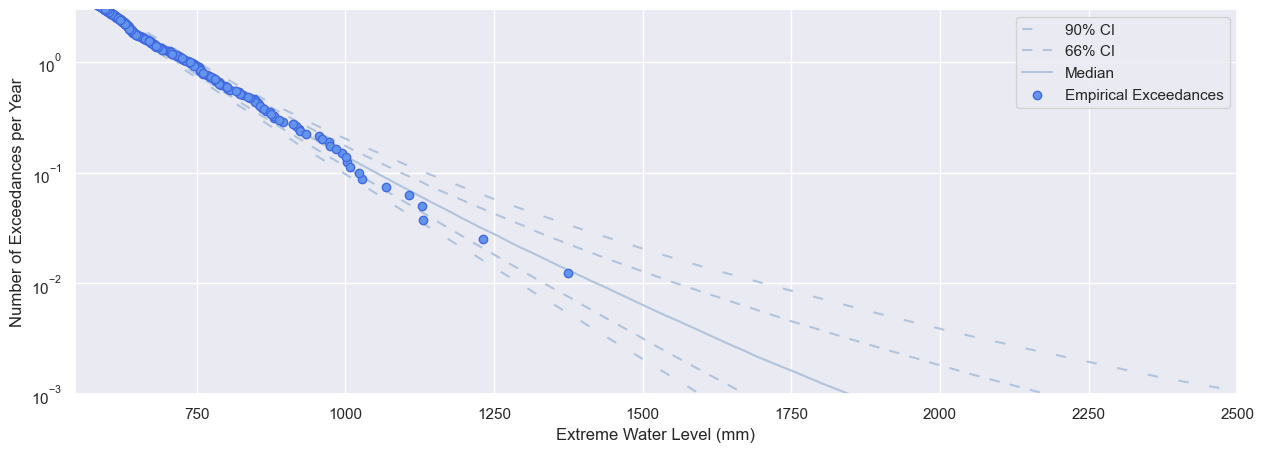

In [36]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.plot(z, q5, color = 'lightsteelblue', linestyle = (0, (5,10)), label = '90% CI')
plt.plot(z, q17, color = 'lightsteelblue', linestyle = (0, (5,5)), label = '66% CI')
plt.plot(z, q50, color = 'lightsteelblue', label = 'Median')
plt.plot(z, q83, color = 'lightsteelblue', linestyle = (0, (5,5)))
plt.plot(z, q95, color = 'lightsteelblue', linestyle = (0, (5,10)))
plt.scatter(testexc_tg, exceeded_tide, facecolors = 'cornflowerblue', edgecolors = 'royalblue', label = 'Empirical Exceedances', zorder = 10000)
plt.plot()

ax.set_yscale('log')
ax.set_ylim([1e-3, 3])
ax.set_xlim([545, 2500])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Number of Exceedances per Year', fontsize = 12)
plt.legend(loc = "upper right")


In [57]:
pmpd_geo = pm.ParaDRAM()

In [58]:
pmpd_geo.spec.overwriteRequested = True # overwrite the existing output files just in case they already exist.
pmpd_geo.spec.outputFileName = "./out/ESL&GS_S_MCMC" # specify the output file prefixes.
pmpd_geo.spec.randomSeed = 12345 # set the random seed for the sake of reproducibity.
pmpd_geo.spec.variableNameList = ["mu", "phi", "xi", "tau"] # set the output names of the parameters.
pmpd_geo.spec.chainSize = 20000 # set the number of uniquely sampled points from the likelihood function.
pmpd_geo.spec.domainLowerLimitVec = [400, 100, 1e-10, 1000]
pmpd_geo.spec.domainUpperLimitVec = [1000, 500, 1, 1500] 

In [59]:
pmpd_geo.runSampler( ndim = 4, # the number of parameters
               getLogFunc = log_likelihood # the objective function to sample points from
               )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                    

                                     20000 / 42072             0.5133 / 0.4761             0.2607 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

In [60]:
chain_geo = pmpd_geo.readChain(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readChain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/ESL&GS_S_MCMC*_chain.txt"


ParaDRAM - NOTE: processing chain file: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms/out/ESL&GS_S_MCMC_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 0.031029 seconds.
ParaDRAM - NOTE: ndim = 4, count = 20000
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating a h

In [61]:
chain_geo.plot.scatter.scatter.kws.cmap = "winter" # change the color-mapping from the default "autumn"
# chain_geo.plot.scatter( ycolumns = "AdaptationMeasure" # choose the AdaptationMeasure column of the output chain file to plot
#                   , ccolumns = [] # set the color of the points to empty from the default logLikelihood value.
#                   )
# chain_geo.plot.scatter.currentFig.axes.set_ylim([1.e-5,1])
# chain_geo.plot.scatter.currentFig.axes.set_yscale("log")

In [62]:
sample_geo = pmpd_geo.readSample(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readSample()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the sample file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/ESL&GS_S_MCMC*_sample.txt"


ParaDRAM - NOTE: processing sample file: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms/out/ESL&GS_S_MCMC_process_1_sample.txt
ParaDRAM - NOTE: reading the file contents... done in 0.005385 seconds.
ParaDRAM - NOTE: ndim = 4, count = 3381
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating

In [30]:
# for colname in sample_geo.df.columns:
#     sample_geo.plot.line.ycolumns = colname
#     sample_geo.plot.line()
#     sample_geo.plot.line.currentFig.axes.set_xlabel("MCMC Count")
#     sample_geo.plot.line.currentFig.axes.set_ylabel(colname)
#     sample_geo.plot.line.savefig( fname = "./out/traceplot_" + colname )

# # plot the histograms of the sampled parameters

# for colname in sample_geo.df.columns:
#     sample_geo.plot.histplot(xcolumns = colname)
#     sample_geo.plot.histplot.currentFig.axes.set_xlabel(colname)
#     sample_geo.plot.histplot.currentFig.axes.set_ylabel("MCMC Count")
#     sample_geo.plot.histplot.savefig( fname = "./out/histogram_" + colname )

In [63]:
sample_geo.df.mean()

SampleLogFunc     -60.246049
mu                566.207554
phi               137.481160
xi                  0.119400
tau              1345.302095
dtype: float64

In [64]:
sample_geo.df.std()

SampleLogFunc      0.787532
mu               113.960842
phi               27.217841
xi                 0.076586
tau              106.074534
dtype: float64

In [45]:
sample_geo.df.quantile([0.05, 0.5, 0.95])

,SampleLogFunc,mu,phi,xi,tau
0.05,-1810.78949,708.890165,116.422296,0.005940,1251.138055
0.50,-1808.22585,726.635045,126.803680,0.058102,1369.320600
0.95,-1807.21600,748.832280,139.149150,0.120735,1470.492565


ParaDRAM - NOTE: making the grid plot... 
generating subplot #1: (0,0) out of 16... done in 0.020087 seconds.
generating subplot #2: (0,1) out of 16... done in 0.182484 seconds.
generating subplot #3: (0,2) out of 16... done in 0.183398 seconds.
generating subplot #4: (0,3) out of 16... done in 0.179635 seconds.
generating subplot #5: (1,0) out of 16... done in 0.337154 seconds.
generating subplot #6: (1,1) out of 16... done in 0.020087 seconds.
generating subplot #7: (1,2) out of 16... done in 0.176303 seconds.
generating subplot #8: (1,3) out of 16... done in 0.178528 seconds.
generating subplot #9: (2,0) out of 16... done in 0.311164 seconds.
generating subplot #10: (2,1) out of 16... done in 0.437367 seconds.
generating subplot #11: (2,2) out of 16... done in 0.020087 seconds.
generating subplot #12: (2,3) out of 16... done in 0.175735 seconds.
generating subplot #13: (3,0) out of 16... done in 0.314852 seconds.
generating subplot #14: (3,1) out of 16... done in 0.471143 seconds.
g

AttributeError: 'Struct' object has no attribute 'axes'

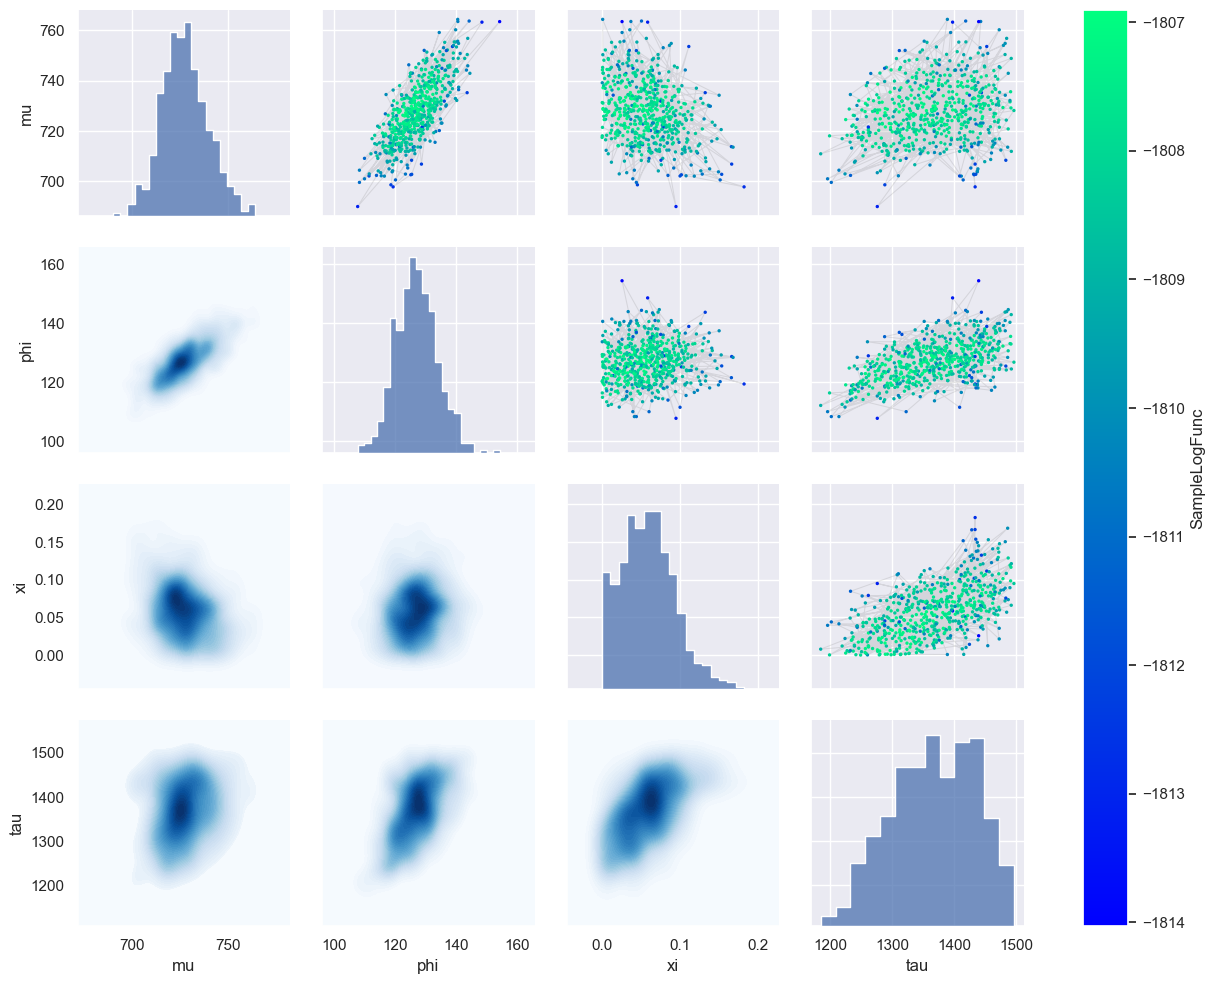

In [52]:
sample_geo.plot.grid.plotType.upper.enabled = True # disable upper triangle
sample_geo.plot.grid.plotType.lower.value = "contourf" # let lower triangle be lineScatter plot
sample_geo.plot.grid(columns = [1,2,3,4]) # make grid plot of all parameters
# sample_geo.plot.grid.addTarget() # add the maximum-likelihood set of parameters as the target value to all plots

sample_geo.plot.grid.currentFig.axes.set_xlim(250,1000)

plt.savefig("Synthetic_MCMC_Params_Both", bbox_inches = 'tight', dpi = 300)


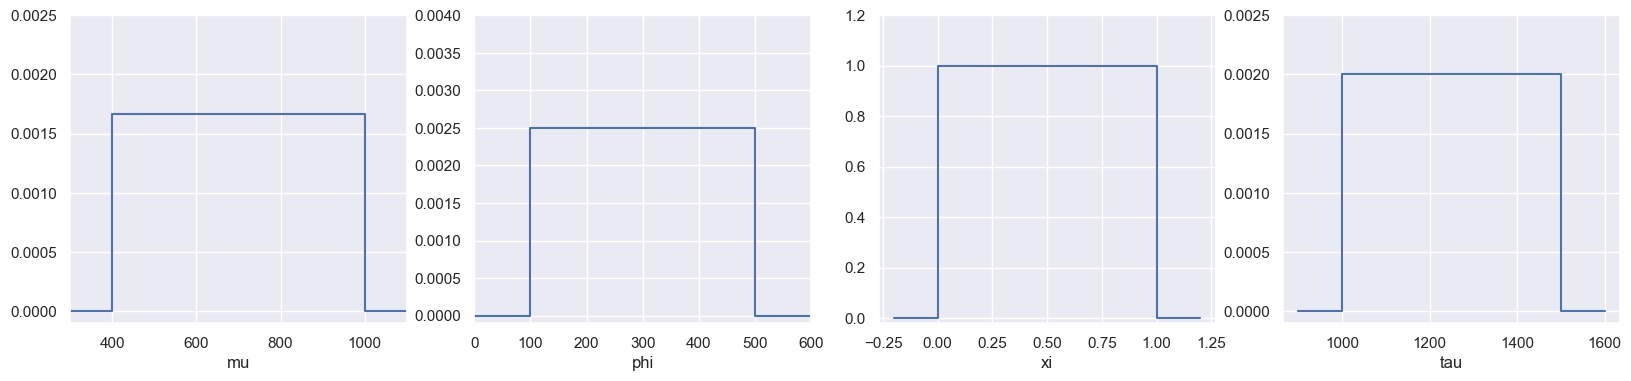

In [132]:
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(141)

x1 = (300, 400, 400, 1000, 1000, 1100)
y1 = (0, 0,(1/600), (1/600), 0, 0)

plt.plot(x1,y1)

plt.xlabel('mu', fontsize = 12)

ax.set_xlim(300,1100)
ax.set_ylim([-0.0001,0.0025])

ax2 = fig.add_subplot(142)

x2 = (0, 100, 100, 500, 500, 600)
y2 = (0, 0,(1/400), (1/400), 0, 0)

plt.plot(x2,y2)

plt.xlabel('phi', fontsize = 12)

ax2.set_xlim([0,600])
ax2.set_ylim([-0.0001,0.004])

ax3 = fig.add_subplot(143)

x3 = (-0.2, 1e-10, 1e-10, 1, 1, 1.2)
y3 = (0, 0,(1/(1-1e-10)), (1/(1-1e-10)), 0, 0)

plt.plot(x3,y3)

plt.xlabel('xi', fontsize = 12)

ax3.set_ylim([-0.02,1.2])

ax4 = fig.add_subplot(144)

x4 = (900, 1000, 1000, 1500, 1500, 1600)
y4 = (0, 0,(1/500), (1/500), 0, 0)

plt.plot(x4,y4)

plt.xlabel('tau', fontsize = 12)

ax4.set_ylim([-0.0001,0.0025])

plt.savefig("Priors.png", bbox_inches = 'tight', dpi = 300)


ParaDRAM - NOTE: making the grid plot... 
generating subplot #1: (0,0) out of 16... done in 0.019327 seconds.
generating subplot #2: (0,1) out of 16... done in 0.186583 seconds.
generating subplot #3: (0,2) out of 16... done in 0.186982 seconds.
generating subplot #4: (0,3) out of 16... done in 0.187543 seconds.
generating subplot #5: (1,0) out of 16... done in 0.319749 seconds.
generating subplot #6: (1,1) out of 16... done in 0.019327 seconds.
generating subplot #7: (1,2) out of 16... done in 0.186542 seconds.
generating subplot #8: (1,3) out of 16... done in 0.18513 seconds.
generating subplot #9: (2,0) out of 16... done in 0.321567 seconds.
generating subplot #10: (2,1) out of 16... done in 0.309895 seconds.
generating subplot #11: (2,2) out of 16... done in 0.019327 seconds.
generating subplot #12: (2,3) out of 16... done in 0.186404 seconds.
generating subplot #13: (3,0) out of 16... done in 0.319477 seconds.
generating subplot #14: (3,1) out of 16... done in 0.331526 seconds.
ge

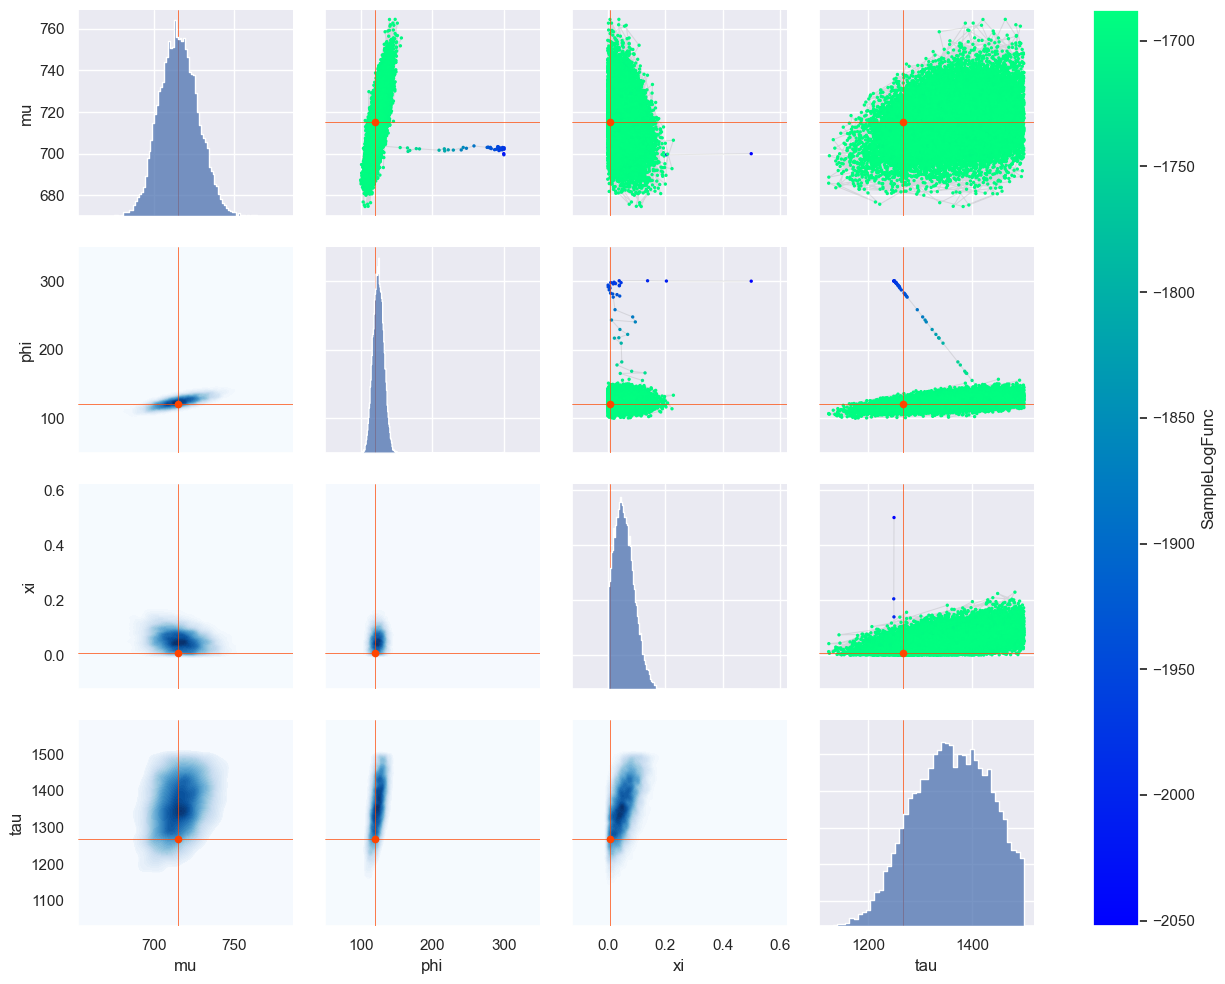

In [52]:
chain_geo.plot.grid.plotType.lower.value = "contourf"
chain_geo.plot.grid(columns = [7,8,9,10])
chain_geo.plot.grid.addTarget()

In [47]:
sample_geo.df

,SampleLogFunc,mu,phi,xi,tau
0,-1810.4251,703.77619,119.05111,0.149649,1437.7225
1,-1809.8861,704.18278,119.22632,0.126991,1437.9226
2,-1810.1313,704.96095,118.04160,0.138341,1438.7193
3,-1810.7921,702.88672,123.44051,0.128784,1431.7050
4,-1812.7419,697.80375,119.37186,0.182579,1434.1963
...,...,...,...,...,...
605,-1807.6822,725.66678,124.36234,0.080995,1413.0625
606,-1809.5979,710.99414,126.52570,0.102829,1377.8022
607,-1808.2447,721.57717,121.79223,0.069539,1420.0693
608,-1810.3743,706.47864,123.99336,0.114558,1361.3231


In [48]:
runs = len(sample_geo.df)

z = []
for i in range(515, 5000):
    z.append(i) 
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append (x) # water heights to calculate return periods for

param_num = []
for x in range(0, len(sample_geo.df)):
    param_num.append(x)

def n_z_geo (z):
    
    mcmc_curves_tide = []
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    
    for i in range(0, runs):
        
        expected_per_z = []
        
        for j in range(0, len(water_height_nums)):
            
            # optimized parameter values
            mu = sample_geo.df.loc[i, 'mu']
            phi = sample_geo.df.loc[i, 'phi']
            xi = sample_geo.df.loc[i, 'xi']
            
            c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
            expected_per_z.append(c)
            
        plt.plot(z, expected_per_z, color = 'lightgray')         
    
    plt.plot(testz, testlogNexc, color = 'gray', label = 'True Return Curve')
    plt.scatter(testexc_tg, exceeded_tide, facecolors = 'none', edgecolors = 'cyan', label = 'Empirical Exceedances', zorder = 10000)

    ax.set_yscale('log')
    ax.set_ylim([1e-3, 1])
    ax.set_xlim([500, 3000])
    plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
    plt.ylabel('Number of Exceedances per Year', fontsize = 12)
    plt.legend(loc = "upper right")
    
    plt.savefig("Synthetic_MCMC_Runs_Geo", bbox_inches = 'tight', dpi = 300)

    return ()


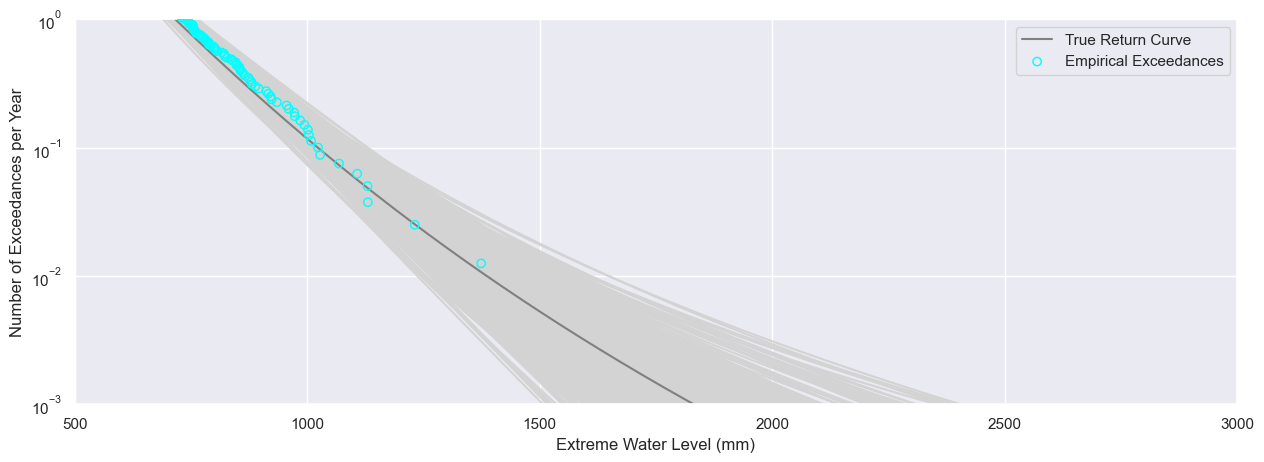

In [49]:
mcmc_curves_geo = n_z_geo(z)

In [50]:
# Quantiles for MCMC runs

z = []
for i in range(545, 3001):
    z.append(i)
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append(x)

geoq5 = []
geoq50 = []
geoq95 = []
geoq17 = []
geoq83 = []
    
for i in range(0, len(water_height_nums)):
    
    geoy = []
    
    for j in range(0, runs):
        
        # optimized parameter values
        mu = sample_geo.df.loc[j, 'mu']
        phi = sample_geo.df.loc[j, 'phi']
        xi = sample_geo.df.loc[j, 'xi']
        
        c = ((1 + (xi * (z[i] - mu)/phi))**(-1/xi))
        geoy.append(c)
        
    geoy_q5 = np.quantile(geoy, 0.05)
    geoq5.append(geoy_q5)
    geoy_q50 = np.quantile(geoy, 0.50)
    geoq50.append(geoy_q50)
    geoy_q95 = np.quantile(geoy, 0.95)
    geoq95.append(geoy_q95)
    geoy_q17 = np.quantile(geoy, 0.17)
    geoq17.append(geoy_q17)
    geoy_q83 = np.quantile(geoy, 0.83)
    geoq83.append(geoy_q83)
    
geofin = np.column_stack((z, geoq5, geoq17, geoq50, geoq83, geoq95))

geofin = pd.DataFrame(geofin, columns = ['Water Level (mm)', 'q5', 'q17', 'q50', 'q83', 'q95'])

geofin.to_excel('geo_quantiles.xlsx', index = False)

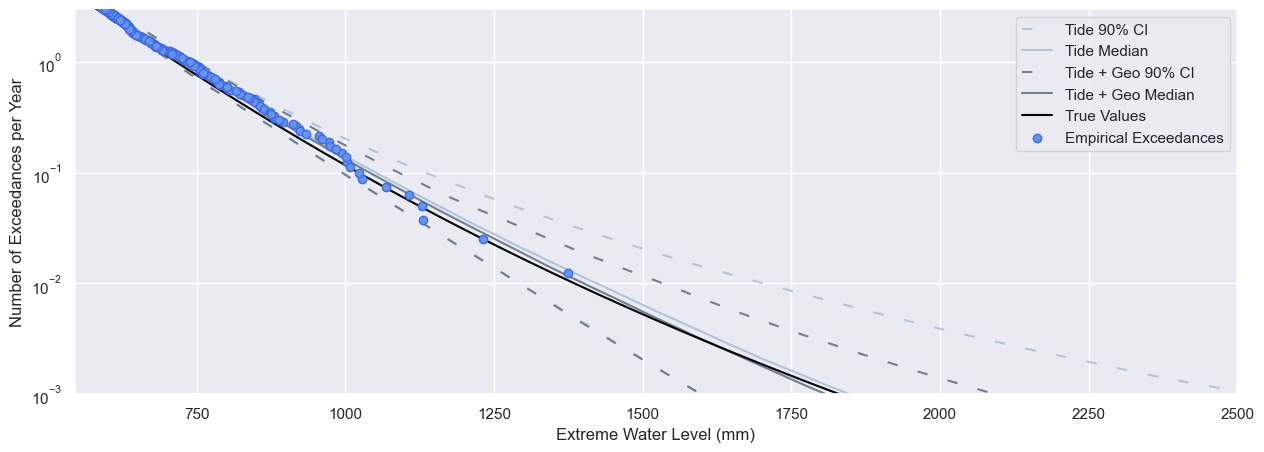

In [51]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.plot(z, q5, color = 'lightsteelblue', linestyle = (0, (5,10)), label = 'Tide 90% CI')
# plt.plot(z, q17, color = 'lightsteelblue', linestyle = (0, (5,5)), label = 'Tide 66% CI')
plt.plot(z, q50, color = 'lightsteelblue', label = 'Tide Median')
# plt.plot(z, q83, color = 'lightsteelblue', linestyle = (0, (5,5)))
plt.plot(z, q95, color = 'lightsteelblue', linestyle = (0, (5,10)))

plt.plot(z, geoq5, color = 'slategray', linestyle = (0, (5,10)), label = 'Tide + Geo 90% CI')
# plt.plot(z, geoq17, color = 'slategray', linestyle = (0, (5,5)), label = 'Tide + Geo 66% CI')
plt.plot(z, geoq50, color = 'slategray', label = 'Tide + Geo Median')
# plt.plot(z, geoq83, color = 'slategray', linestyle = (0, (5,5)))
plt.plot(z, geoq95, color = 'slategray', linestyle = (0, (5,10)))
plt.plot(testz, testlogNexc, color = 'black', label = 'True Values')
plt.scatter(testexc_tg, exceeded_tide, facecolors = 'cornflowerblue', edgecolors = 'royalblue', label = 'Empirical Exceedances', zorder = 10000)


ax.set_yscale('log')
ax.set_ylim([1e-3, 3])
ax.set_xlim([545, 2500])
ax.legend()
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Number of Exceedances per Year', fontsize = 12)

plt.savefig("MCMCSynthetic.pdf", bbox_inches = 'tight', dpi = 300)


In [ ]:
# CREATE MULTIPLE DATASETS VIA BOOTSTRAPPING

bs_q99 = []
bs_tg_h99 = []

for _ in range(1000):
    x = np.random.choice(tg_h_notrend, size = len(tg_h_notrend), replace = True)
    y = np.quantile(tg_h_notrend, 0.99)
    z = x[(x >= y)]
    bs_tg_h99.append(z)
    bs_q99.append(y)

In [ ]:
# MAXIMUM LIKELIHOOD ESTIMATION

parameters0 = [600.0, 120.0, 0.200]
num_od = cutoff_data[geologic_id]

def function_a(z, parameters): # just a funciton used in both likelihood functions
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    
    return (np.log(1 + (xi * ((z - mu)/phi))))

# negative log likelihood for tide data & proxy data    
def negative_log_likelihood(parameters, q_99, num_od, tg_h_notrend99):
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    tau = parameters[3]
    q99 = q_99
    
    tg_z = tg_h_notrend99 # tide gauge water levels
    N = len(tg_z) # number of tide gauge water levels over tide_threshold
    M = num_od # number of geologic observations
    
    t1 = 1000
    t2 = 2000
    t_tide = 1920
    
    nll_geo_tide = ((N * np.log(phi)) + ((1 + (1/xi)) * np.sum(function_a(tg_z, parameters))) +
        ((M/xi) * np.log(1 + (xi * ((tau - mu)/phi)))) +
        ((t2 - t_tide) * (1 + ((xi * (q99 - mu))/phi))**(-1/xi)) +
        ((t_tide - t1) * (1 + ((xi * (tau - mu))/phi))**(-1/xi)))
    
    return(nll_geo_tide) 

# negative log likelihood for tide data only
def negative_log_likelihood_tide(parameters, q_99, tg_h_notrend99):
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    q99 = q_99
    
    tg_z = tg_h_notrend99 # tide gauge water levels
    N = len(tg_z) # number of tide gauge water levels over tide_threshold
    
    t2 = 2000
    t_tide = 1920 # start of tide gauge record
    
    nll_tide = ((N * np.log(phi)) + ((1 + (1/xi)) * np.sum(function_a(tg_z, parameters))) +
        ((t2 - t_tide) * (1 + ((xi * (q99 - mu))/phi))**(-1/xi)))
    
    return(nll_tide)


In [ ]:
parametersb = [600, 120.0, 0.1, 1500]
parametersa = [600, 120.0, 0.1]

# test negative log likelihood function - testing with true parameter values
ans = negative_log_likelihood(parametersb, q99, num_od, tg_h_notrend99)
print(ans)

ans1 = negative_log_likelihood_tide(parametersa, q99, tg_h_notrend99)
print(ans1)

In [ ]:
# MAXIMUM LIKELIHOOD ESTIMATES

# create single MLE
parametersa0 = [600, 200, 0.2] # starting values for optimization
parametersb0 = [600, 200, 0.2, 1400]

bndsa = ((0, 800), (1, 400), (1e-3, 1))
bndsb = ((0, 800), (1, 400), (1e-3, 1), (1000, 2000))

#result = scipy.optimize.minimize(negative_log_likelihood, parameters, method = 'Nelder-Mead')
result = scipy.optimize.minimize(negative_log_likelihood, parametersb0, args = (q99, num_od, tg_h_notrend99), method = 'Powell', bounds = bndsb)
print(result)
#result1 = scipy.optimize.minimize(negative_log_likelihood_tide, parameters, method = 'Nelder-Mead')
result1 = scipy.optimize.minimize(negative_log_likelihood_tide, parametersa0, args = (q99, tg_h_notrend99), method = 'Powell', bounds = bndsa)
print(result1)

In [ ]:
# CREATE MULTIPLE MLEs

def list_of_mles():
    
    mles = []            
    for i in range (0, num_its):
        bnds = ((0, 1000), (1, 500), (1e-3, 1), (0,3000))
        b = scipy.optimize.minimize(negative_log_likelihood, parametersb0, args = (bs_q99[i], num_od, bs_tg_h99[i]), method = 'Powell', bounds = bnds)
        mles.append(b)
            
    return(mles)
    
def list_of_mles_tide():
    
    mles_tide = []
    for i in range (0,num_its):
        bnds = ((0, 1000), (1, 800), (1e-3, 1))
        b = scipy.optimize.minimize(negative_log_likelihood_tide, parametersa0, args = (bs_q99[i], bs_tg_h99[i]), method = 'Powell', bounds = bnds)
        mles_tide.append(b)
        
    return(mles_tide)



In [ ]:
# LIST OF MLEs

num_its = 1000

mles = list_of_mles()
mles_tide = list_of_mles_tide()


In [ ]:
# PARAMETER ESTIMATES

mle_estimates = pd.DataFrame(mles)
parameter_estimates = mle_estimates['x']
parameter_estimates = parameter_estimates.tolist()
mus = [i[0] for i in parameter_estimates]
phis = [i[1] for i in parameter_estimates]
xis = [i[2] for i in parameter_estimates]
Ms = [i[3] for i in parameter_estimates]
parameter_estimates = pd.DataFrame(list(zip(mus, phis, xis, Ms)), columns = ['Mu', 'Phi', 'Xi', 'Tau'])

# table_tide_parameters = parameter_estimates.describe(percentiles = [0.05, 0.50, 0.95])
# table_tide_parameters.to_csv('TideParameterStats_MCMCGeo_Synthetic_StationaryCase')

mle_estimates_tide = pd.DataFrame(mles_tide)
parameter_estimates_tide = mle_estimates_tide['x']
parameter_estimates_tide = parameter_estimates_tide.tolist()
mus_tide = [i[0] for i in parameter_estimates_tide]
phis_tide = [i[1] for i in parameter_estimates_tide]
xis_tide = [i[2] for i in parameter_estimates_tide]
parameter_estimates_tide = pd.DataFrame(list(zip(mus_tide, phis_tide, xis_tide)), columns = ['Mu', 'Phi', 'Xi'])

# table_tide_parameters = parameter_estimates_tide.describe(percentiles = [0.05, 0.50, 0.95])
# table_tide_parameters.to_csv('TideParameterStats_MCMC_Synthetic_StationaryCase')


In [ ]:
# MLE MODEL OUTPUTS FROM TG DATA ALONE 

z = []
for i in range(545, 3001):
    z.append(i)
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append(x)
    
param_num = []
for x in range(0, len(parameter_estimates_tide)):
    param_num.append(x)

mletideq5 = []
mletideq50 = []
mletideq95 = []
mletideq17 = []
mletideq83 = []

    
for i in range(0, len(water_height_nums)):
    
    mletidey = []
    
    for j in range(0, len(param_num)):
        
        # optimized parameter values
        mu = parameter_estimates_tide.loc[j, 'Mu']
        phi = parameter_estimates_tide.loc[j, 'Phi']
        xi = parameter_estimates_tide.loc[j, 'Xi']
        
        c = ((1 + (xi * (z[i] - mu)/phi))**(-1/xi))
        mletidey.append(c)
        
    mletidey_q5 = np.quantile(mletidey, 0.05)
    mletideq5.append(mletidey_q5)
    mletidey_q50 = np.quantile(mletidey, 0.50)
    mletideq50.append(mletidey_q50)
    mletidey_q95 = np.quantile(mletidey, 0.95)
    mletideq95.append(mletidey_q95)
    mletidey_q17 = np.quantile(mletidey, 0.17)
    mletideq17.append(mletidey_q17)
    mletidey_q83 = np.quantile(mletidey, 0.83)
    mletideq83.append(mletidey_q83)
    
mletidefin = np.column_stack((z, mletideq5, mletideq17, mletideq50, mletideq83, mletideq95))

mletidefin = pd.DataFrame(mletidefin, columns = ['Water Level (mm)', 'q5', 'q17', 'q50', 'q83', 'q95'])

mletidefin.to_excel('mle_tide_quantiles.xlsx', index = False)

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.plot(z, mletideq5, color = 'lightcoral', linestyle = (0, (5,10)), label = '5th-95th')
plt.plot(z, mletideq17, color = 'lightcoral', linestyle = (0, (5,5)), label = '17th-83rd')
plt.plot(z, mletideq50, color = 'lightcoral', label = '50th')
plt.plot(z, mletideq83, color = 'lightcoral', linestyle = (0, (5,5)))
plt.plot(z, mletideq95, color = 'lightcoral', linestyle = (0, (5,10)))
plt.scatter(testexc_tg, exceeded_tide, facecolors = 'yellow', edgecolors = 'gold', label = 'Empirical Exceedances', zorder = 10000)

ax.set_yscale('log')
ax.set_ylim([1e-3, 3])
ax.set_xlim([545, 2500])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Number of Exceedances per Year', fontsize = 12)
plt.legend(loc = "upper right")


In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.plot(z, mletideq5, color = 'lightcoral', linestyle = (0, (5,10)), label = '5th-95th')
plt.plot(z, mletideq17, color = 'lightcoral', linestyle = (0, (5,5)), label = '17th-83rd')
plt.plot(z, mletideq50, color = 'lightcoral', label = '50th')
plt.plot(z, mletideq83, color = 'lightcoral', linestyle = (0, (5,5)))
plt.plot(z, mletideq95, color = 'lightcoral', linestyle = (0, (5,10)))
plt.plot(z, q5, color = 'lightsteelblue', linestyle = (0, (5,10)), label = '5th-95th')
plt.plot(z, q17, color = 'lightsteelblue', linestyle = (0, (5,5)), label = '17th-83rd')
plt.plot(z, q50, color = 'lightsteelblue', label = '50th')
plt.plot(z, q83, color = 'lightsteelblue', linestyle = (0, (5,5)))
plt.plot(z, q95, color = 'lightsteelblue', linestyle = (0, (5,10)))
plt.scatter(testexc_tg, exceeded_tide, facecolors = 'yellow', edgecolors = 'gold', label = 'Empirical Exceedances', zorder = 10000)

ax.set_yscale('log')
ax.set_ylim([1e-3, 3])
ax.set_xlim([545, 2500])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Number of Exceedances per Year', fontsize = 12)
plt.legend(loc = "upper right")


In [ ]:
# MLE MODEL OUTPUTS FROM TG DATA ALONE 

z = []
for i in range(545, 3001):
    z.append(i)
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append(x)
    
param_num = []
for x in range(0, len(parameter_estimates)):
    param_num.append(x)

mlegeoq5 = []
mlegeoq50 = []
mlegeoq95 = []
mlegeoq17 = []
mlegeoq83 = []

    
for i in range(0, len(water_height_nums)):
    
    mlegeoy = []
    
    for j in range(0, len(param_num)):
        
        # optimized parameter values
        mu = parameter_estimates.loc[j, 'Mu']
        phi = parameter_estimates.loc[j, 'Phi']
        xi = parameter_estimates.loc[j, 'Xi']
        
        c = ((1 + (xi * (z[i] - mu)/phi))**(-1/xi))
        mlegeoy.append(c)
        
    mlegeoy_q5 = np.quantile(mlegeoy, 0.05)
    mlegeoq5.append(mlegeoy_q5)
    mlegeoy_q50 = np.quantile(mlegeoy, 0.50)
    mlegeoq50.append(mlegeoy_q50)
    mlegeoy_q95 = np.quantile(mlegeoy, 0.95)
    mlegeoq95.append(mlegeoy_q95)
    mlegeoy_q17 = np.quantile(mlegeoy, 0.17)
    mlegeoq17.append(mlegeoy_q17)
    mlegeoy_q83 = np.quantile(mlegeoy, 0.83)
    mlegeoq83.append(mlegeoy_q83)
    
mlegeofin = np.column_stack((z, mlegeoq5, mlegeoq17, mlegeoq50, mlegeoq83, mlegeoq95))

mlegeofin = pd.DataFrame(mlegeofin, columns = ['Water Level (mm)', 'q5', 'q17', 'q50', 'q83', 'q95'])

mlegeofin.to_excel('mle_geo_quantiles.xlsx', index = False)

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.plot(z, mlegeoq5, color = 'rosybrown', linestyle = (0, (5,10)), label = '5th-95th')
plt.plot(z, mlegeoq17, color = 'rosybrown', linestyle = (0, (5,5)), label = '17th-83rd')
plt.plot(z, mlegeoq50, color = 'rosybrown', label = '50th')
plt.plot(z, mlegeoq83, color = 'rosybrown', linestyle = (0, (5,5)))
plt.plot(z, mlegeoq95, color = 'rosybrown', linestyle = (0, (5,10)))
plt.scatter(testexc_tg, exceeded_tide, facecolors = 'yellow', edgecolors = 'gold', label = 'Empirical Exceedances', zorder = 10000)

ax.set_yscale('log')
ax.set_ylim([1e-3, 3])
ax.set_xlim([545, 2500])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Number of Exceedances per Year', fontsize = 12)
plt.legend(loc = "upper right")


In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.plot(z, mletideq5, color = 'lightcoral', linestyle = (0, (5,10)), label = '5th-95th')
plt.plot(z, mletideq17, color = 'lightcoral', linestyle = (0, (5,5)), label = '17th-83rd')
plt.plot(z, mletideq50, color = 'lightcoral', label = '50th')
plt.plot(z, mletideq83, color = 'lightcoral', linestyle = (0, (5,5)))
plt.plot(z, mletideq95, color = 'lightcoral', linestyle = (0, (5,10)))
plt.plot(z, mlegeoq5, color = 'rosybrown', linestyle = (0, (5,10)), label = '5th-95th')
plt.plot(z, mlegeoq17, color = 'rosybrown', linestyle = (0, (5,5)), label = '17th-83rd')
plt.plot(z, mlegeoq50, color = 'rosybrown', label = '50th')
plt.plot(z, mlegeoq83, color = 'rosybrown', linestyle = (0, (5,5)))
plt.plot(z, mlegeoq95, color = 'rosybrown', linestyle = (0, (5,10)))
plt.scatter(testexc_tg, exceeded_tide, facecolors = 'yellow', edgecolors = 'gold', label = 'Empirical Exceedances', zorder = 10000)

ax.set_yscale('log')
ax.set_ylim([1e-3, 3])
ax.set_xlim([545, 2500])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Number of Exceedances per Year', fontsize = 12)
plt.legend(loc = "upper right")


In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.plot(z, mlegeoq5, color = 'rosybrown', linestyle = (0, (5,10)), label = '5th-95th')
plt.plot(z, mlegeoq17, color = 'rosybrown', linestyle = (0, (5,5)), label = '17th-83rd')
plt.plot(z, mlegeoq50, color = 'rosybrown', label = '50th')
plt.plot(z, mlegeoq83, color = 'rosybrown', linestyle = (0, (5,5)))
plt.plot(z, mlegeoq95, color = 'rosybrown', linestyle = (0, (5,10)))
plt.plot(z, geoq5, color = 'slategray', linestyle = (0, (5,10)))
plt.plot(z, geoq17, color = 'slategray', linestyle = (0, (5,5)))
plt.plot(z, geoq50, color = 'slategray')
plt.plot(z, geoq83, color = 'slategray', linestyle = (0, (5,5)))
plt.plot(z, geoq95, color = 'slategray', linestyle = (0, (5,10)))
plt.scatter(testexc_tg, exceeded_tide, facecolors = 'yellow', edgecolors = 'gold', label = 'Empirical Exceedances', zorder = 10000)

ax.set_yscale('log')
ax.set_ylim([1e-3, 3])
ax.set_xlim([545, 2500])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Number of Exceedances per Year', fontsize = 12)
plt.legend(loc = "upper right")


In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.plot(z, mletideq5, color = 'lightcoral', linestyle = (0, (5,10)), label = '5th-95th')
# plt.plot(z, mletideq17, color = 'lightcoral', linestyle = (0, (5,5)), label = '17th-83rd')
plt.plot(z, mletideq50, color = 'lightcoral', label = '50th')
# plt.plot(z, mletideq83, color = 'lightcoral', linestyle = (0, (5,5)))
plt.plot(z, mletideq95, color = 'lightcoral', linestyle = (0, (5,10)))
plt.plot(z, q5, color = 'lightsteelblue', linestyle = (0, (5,10)), label = '5th-95th')
# plt.plot(z, q17, color = 'lightsteelblue', linestyle = (0, (5,5)), label = '17th-83rd')
plt.plot(z, q50, color = 'lightsteelblue', label = '50th')
# plt.plot(z, q83, color = 'lightsteelblue', linestyle = (0, (5,5)))
plt.plot(z, q95, color = 'lightsteelblue', linestyle = (0, (5,10)))
plt.plot(z, mlegeoq5, color = 'rosybrown', linestyle = (0, (5,10)), label = '5th-95th')
# plt.plot(z, mlegeoq17, color = 'rosybrown', linestyle = (0, (5,5)), label = '17th-83rd')
plt.plot(z, mlegeoq50, color = 'rosybrown', label = '50th')
# plt.plot(z, mlegeoq83, color = 'rosybrown', linestyle = (0, (5,5)))
plt.plot(z, mlegeoq95, color = 'rosybrown', linestyle = (0, (5,10)))
plt.plot(z, geoq5, color = 'slategray', linestyle = (0, (5,10)))
# plt.plot(z, geoq17, color = 'slategray', linestyle = (0, (5,5)))
plt.plot(z, geoq50, color = 'slategray')
# plt.plot(z, geoq83, color = 'slategray', linestyle = (0, (5,5)))
plt.plot(z, geoq95, color = 'slategray', linestyle = (0, (5,10)))
plt.scatter(testexc_tg, exceeded_tide, facecolors = 'yellow', edgecolors = 'gold', label = 'Empirical Exceedances', zorder = 10000)

ax.set_yscale('log')
ax.set_ylim([1e-3, 3])
ax.set_xlim([545, 2500])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Number of Exceedances per Year', fontsize = 12)
plt.legend(loc = "upper right")
